In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, KFold

In [19]:
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

In [20]:
#Carga del Dataset
try:
    df = pd.read_csv("dataset_elpino.csv", delimiter=';')
    print(f"Dataset cargado: {df.shape[0]} filas y {df.shape[1]} columnas")
except Exception as e:
    print(f"Error al cargar 'dataset_elpino.csv': {e}")

Dataset cargado: 14561 filas y 68 columnas


In [21]:
# ANÁLISIS DE CALIDAD DE DATOS

text_cols = [col for col in df.columns if 'Diag' in col or 'Proced' in col]

In [22]:
# Reemplazar '-' por NaN
df_analysis = df.copy()
df_analysis[text_cols] = df_analysis[text_cols].replace('-', np.nan)

In [23]:
# Calcular el porcentaje de NULOS
null_report = (df_analysis[text_cols].isnull().sum() / len(df_analysis)) * 100
null_report_df = pd.DataFrame({'% Nulo (eran "-")': null_report})


In [24]:
print(null_report_df.sort_values(by='% Nulo (eran "-")', ascending=True).to_markdown())

|                                |   % Nulo (eran "-") |
|:-------------------------------|--------------------:|
| Diag 01 Principal (cod+des)    |            0        |
| Proced 01 Principal (cod+des)  |            0        |
| Proced 02 Secundario (cod+des) |            0.920266 |
| Proced 03 Secundario (cod+des) |            2.34874  |
| Proced 04 Secundario (cod+des) |            4.15493  |
| Proced 05 Secundario (cod+des) |            6.60669  |
| Diag 02 Secundario (cod+des)   |            8.303    |
| Proced 06 Secundario (cod+des) |           10.1641   |
| Proced 07 Secundario (cod+des) |           14.6625   |
| Diag 03 Secundario (cod+des)   |           18.4534   |
| Proced 08 Secundario (cod+des) |           20.6854   |
| Proced 09 Secundario (cod+des) |           27.038    |
| Diag 04 Secundario (cod+des)   |           28.3428   |
| Proced 10 Secundario (cod+des) |           34.2147   |
| Diag 05 Secundario (cod+des)   |           36.8862   |
| Proced 11 Secundario (cod+des

In [25]:
# ANÁLISIS DE GRD
if 'GRD' in df.columns:
    print("\n\n--- Análisis de la Columna Objetivo: 'GRD' ---")
    
    # Cantidad de clases únicas
    unique_classes = df['GRD'].nunique()
    print(f"Total de categorías únicas (clases): {unique_classes}")
    
    # Distribución de clases 
    print("\n--- Top 10 Clases Más Comunes ---")
    print(df['GRD'].value_counts(normalize=True).head(10) * 100)
    
    # Clases menos comunes
    class_counts = df['GRD'].value_counts()
    classes_con_1_muestra = (class_counts == 1).sum()
    print(f"\n--- Clases Menos Comunes ---")
    print(f"Total de clases con 1 sola muestra: {classes_con_1_muestra}")
else:
    print("ERROR: No se encontró la columna 'GRD'.")



--- Análisis de la Columna Objetivo: 'GRD' ---
Total de categorías únicas (clases): 526

--- Top 10 Clases Más Comunes ---
GRD
146101 - PH CESÁREA                                                                       5.583408
146121 - PH PARTO VAGINAL CON PROCED., EXCEPTO ESTERILIZACIÓN Y/O DILATACIÓN Y LEGRADO    4.388435
146131 - PH PARTO VAGINAL                                                                 3.694801
158171 - MH NEONATO, PESO AL NACER >2499 GR SIN PROCEDIMIENTO MAYOR                       2.671520
134161 - MH TRASTORNOS DEL ANTEPARTO                                                      2.231990
071141 - PH COLECISTECTOMÍA LAPAROSCÓPICA                                                 2.177048
044153 - MH INFECCIONES E INFLAMACIONES RESPIRATORIAS W/MCC                               1.971018
061131 - PH PROCEDIMIENTOS SOBRE APÉNDICE                                                 1.730650
041023 - PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEOSTOMÍA W/MCC            

In [26]:
# Umbral Mínimo
MIN_SAMPLES_PER_CLASS = 5 

print(f"--- Análisis de Curación (Umbral = {MIN_SAMPLES_PER_CLASS} muestras) ---")

--- Análisis de Curación (Umbral = 5 muestras) ---


In [27]:
#Calcular clases que cumplen el umbral
class_counts = df['GRD'].value_counts()
classes_to_keep = class_counts[class_counts >= MIN_SAMPLES_PER_CLASS].index
num_classes_to_keep = len(classes_to_keep)

In [28]:
#Calcular el % de datos y clases que se mantienen dspués de aplicar el umbral
num_rows_to_keep = class_counts[class_counts >= MIN_SAMPLES_PER_CLASS].sum()
percent_rows_kept = (num_rows_to_keep / len(df)) * 100
percent_classes_kept = (num_classes_to_keep / df['GRD'].nunique()) * 100

In [29]:
# Reporte de Impacto de la Curación
print(f"Dataset Original:")
print(f"  - Clases Totales: {df['GRD'].nunique()}")
print(f"  - Filas Totales: {len(df)}")

print(f"\nDataset Curado (Propuesta):")
print(f"  - Nuevas Clases (con >= {MIN_SAMPLES_PER_CLASS} muestras): {num_classes_to_keep}")
print(f"  - Nuevas Filas: {num_rows_to_keep} (retenemos el {percent_rows_kept:.2f}% de los datos)")

print(f"\nIMPACTO: Perderíamos {df['GRD'].nunique() - num_classes_to_keep} clases (la 'cola larga'),")
print(f"         pero solo perderíamos {100 - percent_rows_kept:.2f}% de las filas.")

print(f"\nClases con < {MIN_SAMPLES_PER_CLASS} muestras:")
print((class_counts < MIN_SAMPLES_PER_CLASS).sum())

Dataset Original:
  - Clases Totales: 526
  - Filas Totales: 14561

Dataset Curado (Propuesta):
  - Nuevas Clases (con >= 5 muestras): 327
  - Nuevas Filas: 14135 (retenemos el 97.07% de los datos)

IMPACTO: Perderíamos 199 clases (la 'cola larga'),
         pero solo perderíamos 2.93% de las filas.

Clases con < 5 muestras:
199


In [30]:
# Análisis de 'Edad en años' 
print("\nAnálisis Descriptivo")
print(df['Edad en años'].describe())


Análisis Descriptivo
count    14561.000000
mean        39.426550
std         24.681545
min          0.000000
25%         23.000000
50%         36.000000
75%         60.000000
max        121.000000
Name: Edad en años, dtype: float64


Gráfico 'edad_distribucion.png' guardado.


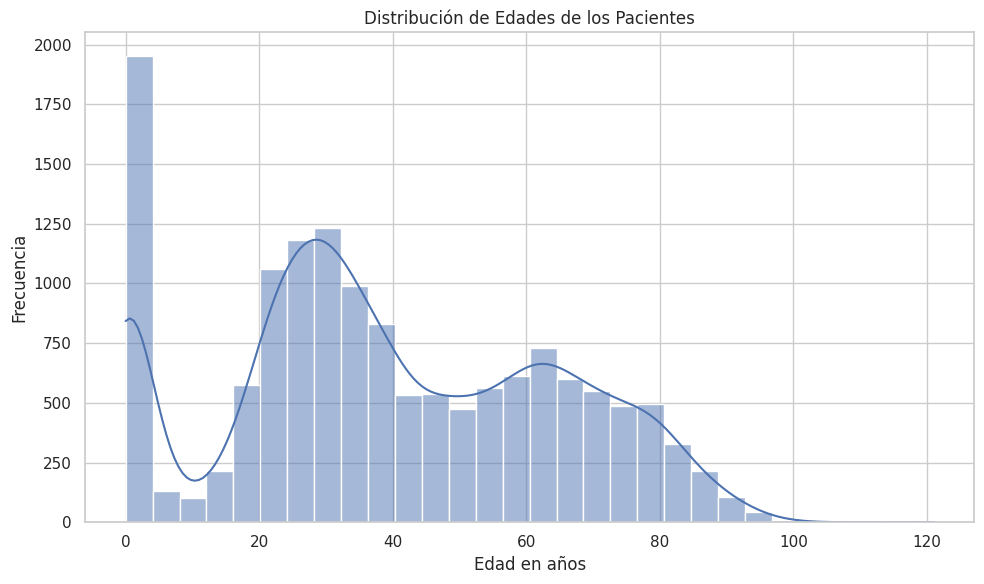

In [31]:
# histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['Edad en años'], bins=30, kde=True)
plt.title('Distribución de Edades de los Pacientes')
plt.xlabel('Edad en años')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.savefig('edad_distribucion.png')
print("Gráfico 'edad_distribucion.png' guardado.")

In [32]:
# Análisis de Sexo
print("\n Análisis Descriptivo: Sexo ")
print(df['Sexo (Desc)'].value_counts())
print("\nDistribución porcentual de Sexo:")
print(df['Sexo (Desc)'].value_counts(normalize=True) * 100)


 Análisis Descriptivo: Sexo 
Sexo (Desc)
Mujer     9617
Hombre    4944
Name: count, dtype: int64

Distribución porcentual de Sexo:
Sexo (Desc)
Mujer     66.046288
Hombre    33.953712
Name: proportion, dtype: float64


Gráfico 'sexo_distribucion.png' guardado.


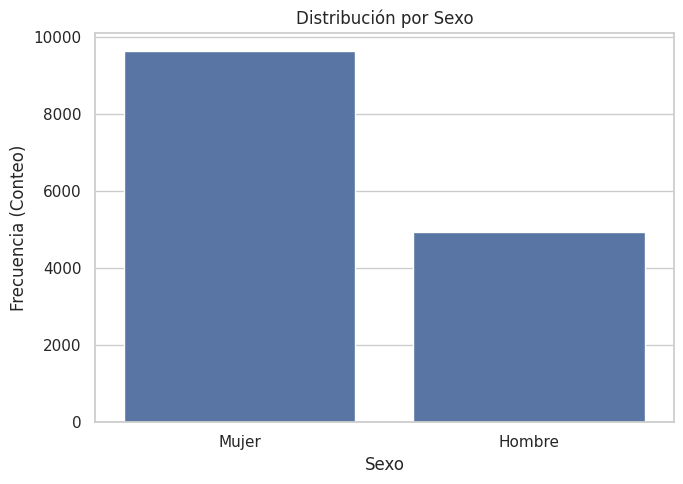

In [33]:
plt.figure(figsize=(7, 5))
sns.countplot(x='Sexo (Desc)', data=df, order=df['Sexo (Desc)'].value_counts().index)
plt.title('Distribución por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Frecuencia (Conteo)')
plt.tight_layout()
plt.savefig('sexo_distribucion.png')
print("Gráfico 'sexo_distribucion.png' guardado.")


 Análisis Descriptivo: GRD (Top 20) 
| GRD                                                                                         | count   |
|:--------------------------------------------------------------------------------------------|:--------|
| 146101 - PH CESÁREA                                                                         | 813     |
| 146121 - PH PARTO VAGINAL CON PROCED., EXCEPTO ESTERILIZACIÓN Y/O DILATACIÓN Y LEGRADO      | 639     |
| 146131 - PH PARTO VAGINAL                                                                   | 538     |
| 158171 - MH NEONATO, PESO AL NACER >2499 GR SIN PROCEDIMIENTO MAYOR                         | 389     |
| 134161 - MH TRASTORNOS DEL ANTEPARTO                                                        | 325     |
| 071141 - PH COLECISTECTOMÍA LAPAROSCÓPICA                                                   | 317     |
| 044153 - MH INFECCIONES E INFLAMACIONES RESPIRATORIAS W/MCC                                 | 287     |
| 061131

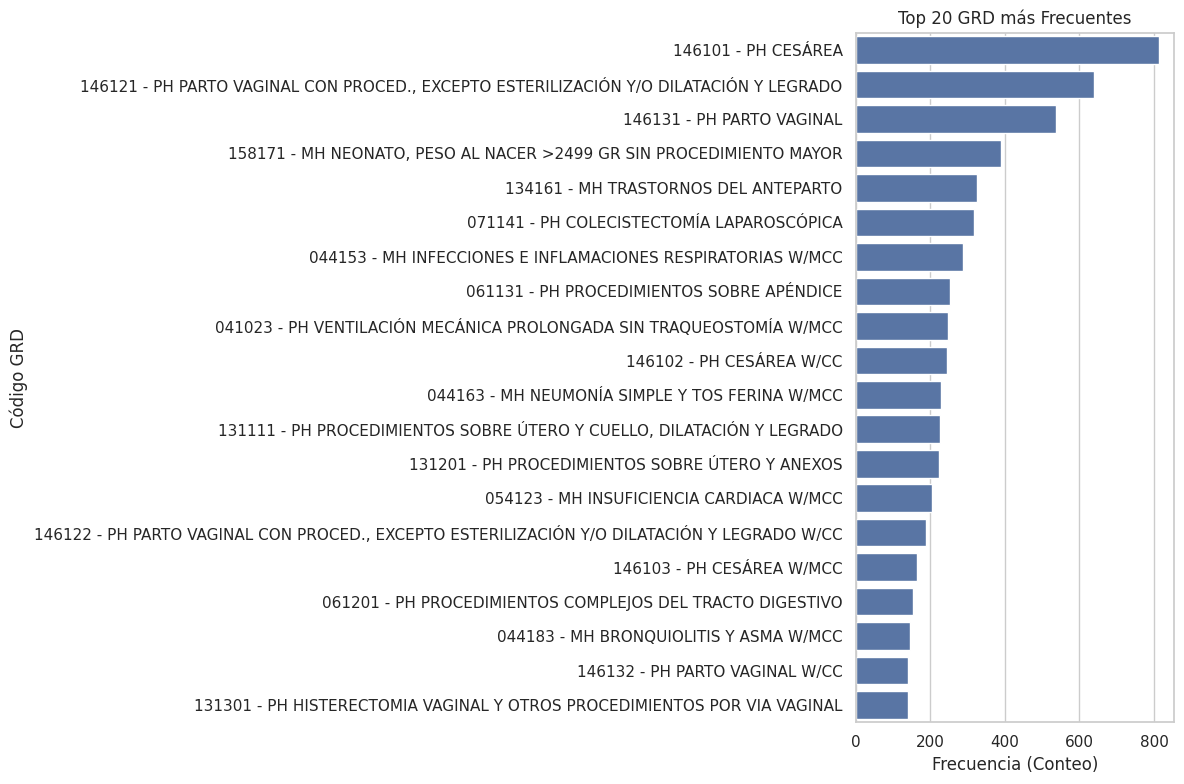

In [34]:
# Análisis de 'GRD' 
print("\n Análisis Descriptivo: GRD (Top 20) ")
grd_counts = df['GRD'].value_counts()
print(grd_counts.head(20).to_markdown(numalign="left", stralign="left"))

plt.figure(figsize=(12, 8))
sns.barplot(
    y=grd_counts.head(20).index, 
    x=grd_counts.head(20).values, 
    orient='h'
)
plt.title('Top 20 GRD más Frecuentes')
plt.xlabel('Frecuencia (Conteo)')
plt.ylabel('Código GRD')
plt.tight_layout()
plt.savefig('grd_top20_distribucion.png')
print("Gráfico 'grd_top20_distribucion.png' guardado.")


--- 5. Generando gráfico de cola larga
Gráfico 'grd_long_tail_distribucion.png' guardado.

--- Análisis Exploratorio de Datos (EDA) completado. ---


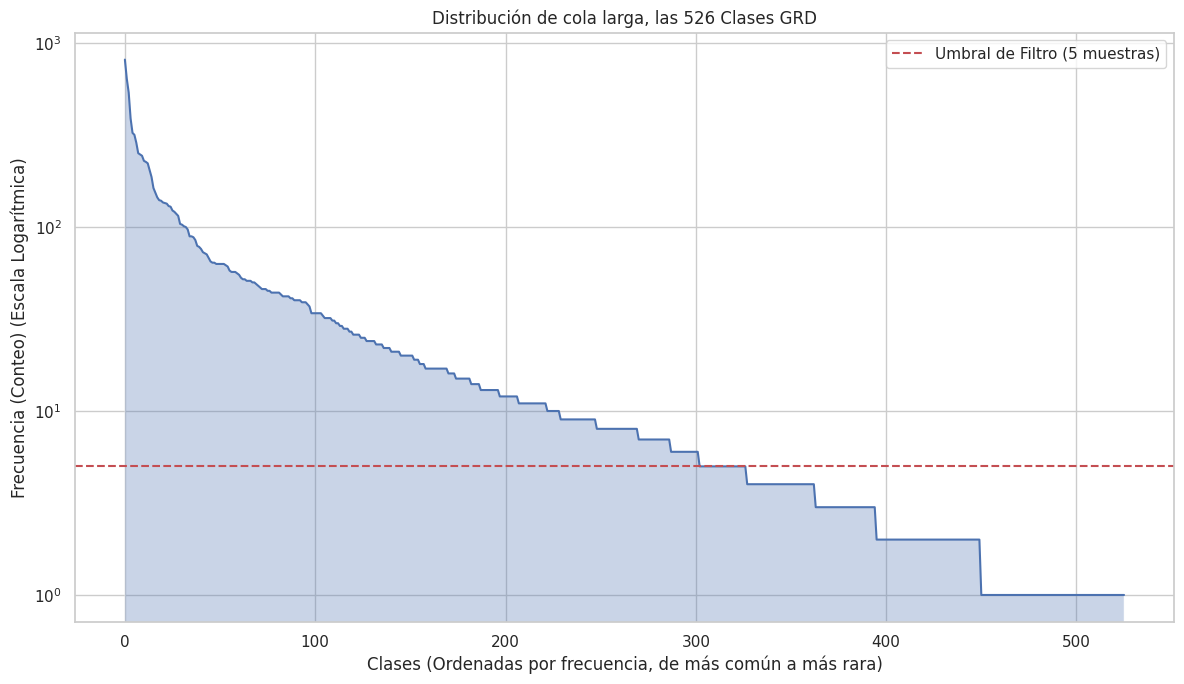

In [35]:
# Gráfico de Cola Larga
print("\n--- 5. Generando gráfico de cola larga")

all_grd_counts_sorted = grd_counts.values
    
plt.figure(figsize=(12, 7))
# Graficar el conteo de cada clase, de mayor a menor
plt.plot(np.arange(len(all_grd_counts_sorted)), all_grd_counts_sorted)
plt.fill_between(np.arange(len(all_grd_counts_sorted)), all_grd_counts_sorted, alpha=0.3)
    
# línea roja en el umbral 5
plt.axhline(y=5, color='r', linestyle='--', label='Umbral de Filtro (5 muestras)')
    
plt.title('Distribución de cola larga, las 526 Clases GRD')
plt.xlabel('Clases (Ordenadas por frecuencia, de más común a más rara)')
plt.ylabel('Frecuencia (Conteo) (Escala Logarítmica)')

plt.yscale('log')
plt.legend()
plt.tight_layout()

plt.savefig('grd_long_tail_distribucion.png')
print("Gráfico 'grd_long_tail_distribucion.png' guardado.")
print("\n--- Análisis Exploratorio de Datos (EDA) completado. ---")

In [36]:
# Curación del Dataset
# Definir el umbral y obtener las clases a mantener
MIN_SAMPLES_PER_CLASS = 5
class_counts = df['GRD'].value_counts()
classes_to_keep = class_counts[class_counts >= MIN_SAMPLES_PER_CLASS].index

# Aplicar el filtro
df_filtrado = df[df['GRD'].isin(classes_to_keep)].copy()
print(f"Dataset filtrado (>= {MIN_SAMPLES_PER_CLASS} muestras/clase): {len(df_filtrado)} filas.")

Dataset filtrado (>= 5 muestras/clase): 14135 filas.


In [37]:
# Extracción de Códigos ---
text_cols = [col for col in df_filtrado.columns if 'Diag' in col or 'Proced' in col]

def extract_code(cell_value):
    return str(cell_value).split(' - ')[0].strip()


df_filtrado.loc[:, text_cols] = df_filtrado[text_cols].applymap(extract_code)
print("Códigos extraídos.")

Códigos extraídos.


/tmp/ipykernel_814/130116571.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_filtrado.loc[:, text_cols] = df_filtrado[text_cols].applymap(extract_code)


In [38]:
# Limpieza de Nulos
df_filtrado.loc[:, text_cols] = df_filtrado[text_cols].replace('-', '')

In [39]:
# Códigos Puros 
df_filtrado['features_texto'] = df_filtrado[text_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df_filtrado['features_texto'] = df_filtrado['features_texto'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

print(df_filtrado[['features_texto']].head())


                                      features_texto
0  A41.8 B37.6 I39.8 N10 B96.1 L89.9 L08.9 B96.2 ...
1  U07.1 J12.8 R06.0 R05 R50.9 Z29.0 Z01.7 J96.00...
2  K56.5 R57.2 R57.1 J80 Y95 J15.0 U82.2 B95.6 B9...
3  K76.8 K66.1 N18.5 D64.9 E87.5 E87.2 J81 N17.8 ...
4  T81.0 Y83.2 S31.1 S36.80 W31.62 J96.09 J15.0 U...


In [40]:
# Definición de X (features) e y (objetivo) ---
X = df_filtrado[['features_texto', 'Edad en años', 'Sexo (Desc)']]
y = df_filtrado['GRD']

In [41]:
# Codificación de 'y' (Objetivo) ---
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)
new_unique_classes = len(np.unique(y_encoded))
print(f"Clases únicas codificadas: {new_unique_classes}") 

Clases únicas codificadas: 327


In [42]:
# División de Datos 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")

Forma de X_train: (11308, 3)
Forma de X_test: (2827, 3)
Forma de y_train: (11308,)
Forma de y_test: (2827,)


In [43]:
# transformadores para cada columna ---

text_processor = TfidfVectorizer(
    max_features=5000,  
    token_pattern=r'\b[A-Za-z0-9]+\b' 
)
numeric_processor = StandardScaler()
categorical_processor = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        
        ('tfidf', text_processor, 'features_texto'),
        ('numeric', numeric_processor, ['Edad en años']),
        ('categorical', categorical_processor, ['Sexo (Desc)'])
    ],
    remainder='drop' 
)


In [44]:
# Modelo Regresión Logística
log_model = LogisticRegression(
    multi_class='multinomial', 
    solver='saga',
    max_iter=1000,       
    random_state=42,
    n_jobs=-1            
)

In [45]:
# Pipeline Completo

pipeline_log = Pipeline(steps=[
    ('preprocessor', preprocessor), # Paso 4
    ('model', log_model)          # Paso 5
])


In [46]:
# Modelo Baseline 
print(f"Iniciando entrenamiento del modelo en {len(y_train)} muestras...")

pipeline_log.fit(X_train, y_train)

print("\n--- ¡Entrenamiento completado! ---")

Iniciando entrenamiento del modelo en 11308 muestras...


/home/fagoncor/tf_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- ¡Entrenamiento completado! ---


In [47]:
# Predicciones 
y_pred_log = pipeline_log.predict(X_test)
print("Predicciones completadas.")

Predicciones completadas.


In [48]:
#  Métricas de Evaluación
f1_macro_log = f1_score(y_test, y_pred_log, average='macro')
f1_weighted_log = f1_score(y_test, y_pred_log, average='weighted')

print(f"  F1-Score (Macro): {f1_macro_log * 100:.2f}%")
print(f"  F1-Score (Weighted): {f1_weighted_log * 100:.2f}%")

  F1-Score (Macro): 18.97%
  F1-Score (Weighted): 49.70%


In [49]:
# Reporte de Clasificación Detallado
print("\n--- Reporte de Clasificación Detallado Baseline ---")
try:
    
    target_names_report = y_encoder.classes_
    report = classification_report(
        y_test, 
        y_pred_log, 
        target_names=target_names_report, 
        zero_division=0
    )
    print(report)
except Exception as e:
    print(f"Error al generar reporte: {e}")
    
    report_fallback = classification_report(y_test, y_pred_log, zero_division=0)
    print(report_fallback)


--- Reporte de Clasificación Detallado Baseline ---
                                                                                                           precision    recall  f1-score   support

                                                        014131 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA       0.00      0.00      0.00         2
                                                   014132 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA W/CC       0.00      0.00      0.00         2
                                                  014133 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA W/MCC       0.00      0.00      0.00         3
                                                        014141 - MH ACCIDENTE CEREBROVASCULAR CON INFARTO       0.50      0.85      0.63        13
                                                   014142 - MH ACCIDENTE CEREBROVASCULAR CON INFARTO W/CC       0.47      0.78      0.58        18
                                                  014143 - MH AC

In [50]:
# Definir el Sampler 
sampler = RandomUnderSampler(random_state=42)

In [51]:
# Pipeline Balanceado 

pipeline_log_balanced = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('sampler', sampler),          
    ('model', log_model)           
])


In [52]:
# Modelo Balanceado
print(f"Iniciando entrenamiento del modelo BALANCEADO en {len(y_train)} muestras...")
pipeline_log_balanced.fit(X_train, y_train)
print("\n--- ¡Entrenamiento del modelo balanceado COMPLETADO! ---")

Iniciando entrenamiento del modelo BALANCEADO en 11308 muestras...


/home/fagoncor/tf_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- ¡Entrenamiento del modelo balanceado COMPLETADO! ---


In [53]:
#Evaluar el Modelo Balanceado 
y_pred_log_balanced = pipeline_log_balanced.predict(X_test)

In [54]:
#Calcular Métricas
f1_macro_bal = f1_score(y_test, y_pred_log_balanced, average='macro')
f1_weighted_bal = f1_score(y_test, y_pred_log_balanced, average='weighted')

print("\n--- Métricas (Regresión Logística CON Undersampling) ---")
print(f"  F1-Score (Macro): {f1_macro_bal * 100:.2f}%")
print(f"  F1-Score (Weighted): {f1_weighted_bal * 100:.2f}%")

print("\n--- Comparación con Baseline ---")
print(f"  Macro Baseline:    {f1_macro_log * 100:.2f}%  ->  Macro Balanceado: {f1_macro_bal * 100:.2f}%")
print(f"  Weighted Baseline: {f1_weighted_log * 100:.2f}%  ->  Weighted Balanceado: {f1_weighted_bal * 100:.2f}%")


--- Métricas (Regresión Logística CON Undersampling) ---
  F1-Score (Macro): 14.38%
  F1-Score (Weighted): 26.92%

--- Comparación con Baseline ---
  Macro Baseline:    18.97%  ->  Macro Balanceado: 14.38%
  Weighted Baseline: 49.70%  ->  Weighted Balanceado: 26.92%


In [55]:
#Clasificación Detallado Balanceado
print("\n Reporte de Clasificación Detallado Balanceado")
try:
    report_balanced = classification_report(
        y_test, 
        y_pred_log_balanced, 
        target_names=y_encoder.classes_, 
        zero_division=0
    )
    print(report_balanced)
except Exception as e:
    print(f"Error al generar reporte: {e}")
    print(classification_report(y_test, y_pred_log_balanced, zero_division=0))


 Reporte de Clasificación Detallado Balanceado
                                                                                                           precision    recall  f1-score   support

                                                        014131 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA       0.00      0.00      0.00         2
                                                   014132 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA W/CC       0.00      0.00      0.00         2
                                                  014133 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA W/MCC       0.01      0.33      0.02         3
                                                        014141 - MH ACCIDENTE CEREBROVASCULAR CON INFARTO       0.11      0.08      0.09        13
                                                   014142 - MH ACCIDENTE CEREBROVASCULAR CON INFARTO W/CC       0.00      0.00      0.00        18
                                                  014143 - MH ACCIDEN

In [56]:
#Importar XGBoost
import xgboost as xgb
from sklearn.metrics import f1_score


In [57]:
#Definir el Modelo XGBoost

if 'new_unique_classes' not in locals():
    print("Variable 'new_unique_classes' no encontrada, asignando 327.")
    new_unique_classes = 327

xgb_model = xgb.XGBClassifier(
    
    device='cuda:0',         
    tree_method='hist',      
    n_jobs=-1,               
        
    objective='multi:softmax',   
    num_class=new_unique_classes, 
    
    max_depth=6,             
    n_estimators=500,        
    learning_rate=0.1,       
         
    random_state=42
)

In [ ]:
# Pipeline Completo 
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', xgb_model)            
])


In [59]:
#Entrenar el Modelo XGBoost
print(f"Iniciando entrenamiento del modelo XGBoost en {len(y_train)} muestras...")
pipeline_xgb.fit(X_train, y_train)


Iniciando entrenamiento del modelo XGBoost en 11308 muestras...


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('numeric', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [60]:
#Evaluar el Modelo XGBoost 
y_pred_xgb = pipeline_xgb.predict(X_test)

/home/fagoncor/tf_env/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [18:48:35] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [61]:
#Calcular Métricas de XGBoost
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average='macro')
f1_weighted_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print("\n Métricas XGBoost")
print(f"  F1-Score (Macro): {f1_macro_xgb * 100:.2f}%")
print(f"  F1-Score (Weighted): {f1_weighted_xgb * 100:.2f}%")


 Métricas XGBoost
  F1-Score (Macro): 33.27%
  F1-Score (Weighted): 60.98%


In [62]:
# Comparación Final
if 'f1_macro_log' not in locals():
    f1_macro_log = 0.1897 
    f1_weighted_log = 0.4970 

print("\n--- Comparación XGBoost vs. Baseline ---")
print(f"  Macro Baseline (LogReg):    {f1_macro_log * 100:.2f}%  ->  Macro XGBoost: {f1_macro_xgb * 100:.2f}%")
print(f"  Weighted Baseline (LogReg): {f1_weighted_log * 100:.2f}%  ->  Weighted XGBoost: {f1_weighted_xgb * 100:.2f}%")


--- Comparación XGBoost vs. Baseline ---
  Macro Baseline (LogReg):    18.97%  ->  Macro XGBoost: 33.27%
  Weighted Baseline (LogReg): 49.70%  ->  Weighted XGBoost: 60.98%


In [63]:
# Importar TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical


2025-11-21 18:48:39.565473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 18:48:39.930656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 18:48:41.575865: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [64]:
# Preprocesar X_train y X_test

X_train_nn = preprocessor.fit_transform(X_train)

X_test_nn = preprocessor.transform(X_test)

In [65]:
# Convertir de Matriz Dispersa a Densa 

X_train_nn_dense = X_train_nn.toarray()
X_test_nn_dense = X_test_nn.toarray()

n_features = X_train_nn_dense.shape[1]
print(f"Forma de X_train_nn_dense: {X_train_nn_dense.shape}")
print(f"Forma de X_test_nn_dense: {X_test_nn_dense.shape}") 
print(f"Total de features de entrada para la NN: {n_features}")

Forma de X_train_nn_dense: (11308, 1333)
Forma de X_test_nn_dense: (2827, 1333)
Total de features de entrada para la NN: 1333


In [66]:
#Preprocesar One-Hot Encoding

y_train_ohe = to_categorical(y_train, num_classes=new_unique_classes)
y_test_ohe = to_categorical(y_test, num_classes=new_unique_classes)

print(f"Forma de y_train_ohe: {y_train_ohe.shape}") 
print(f"Forma de y_test_ohe: {y_test_ohe.shape}")  

Forma de y_train_ohe: (11308, 327)
Forma de y_test_ohe: (2827, 327)


In [67]:
# Importar Callbacks
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
# Verificar variables
if 'n_features' not in locals():
    print("Variables no encontradas, recargando...")
    
    n_features = X_train_nn_dense.shape[1]
    new_unique_classes = y_train_ohe.shape[1]
    print(f"Recargado: {n_features} features, {new_unique_classes} clases.")

In [69]:
# Definir la Arquitectura del Modelo 

inputs = Input(shape=(n_features,))

x = Dense(128, activation='relu')(inputs)
x = Dropout(0.5)(x) 

outputs = Dense(new_unique_classes, activation='softmax')(x)

model_nn = Model(inputs=inputs, outputs=outputs)

I0000 00:00:1763761722.503610     814 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1743 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [70]:
# Compilar el Modelo

model_nn.compile(
   
    optimizer='adam', 
        
    loss='categorical_crossentropy', 
        
    metrics=['accuracy'] 
)

model_nn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1333)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       170,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 327)            │        42,183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,935 (831.78 KB)

 Trainable params: 212,935 (831.78 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
#Definir Callbacks y Entrenar

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_nn = model_nn.fit(
    X_train_nn_dense, 
    y_train_ohe,
    epochs=20,        
    batch_size=64,
    
    validation_data=(X_test_nn_dense, y_test_ohe), 
    
    callbacks=[early_stopping] 
)

Epoch 1/20


2025-11-21 18:48:44.110118: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b67ac008d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-21 18:48:44.110150: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-21 18:48:44.136931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-21 18:48:44.246367: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
2025-11-21 18:48:44.306341: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-21 18:48:45.

 43/177 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0537 - loss: 5.7221

I0000 00:00:1763761727.140291    7735 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0849 - loss: 5.3354

2025-11-21 18:48:47.869151: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-21 18:48:47.869292: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-21 18:48:47.869308: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-21 18:48:48.190712: I external/l

177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.1250 - loss: 4.8224 - val_accuracy: 0.2239 - val_loss: 4.0262
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2678 - loss: 3.7847 - val_accuracy: 0.3378 - val_loss: 3.4122
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3397 - loss: 3.2861 - val_accuracy: 0.4103 - val_loss: 2.9871
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3994 - loss: 2.9224 - val_accuracy: 0.4411 - val_loss: 2.6597
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4370 - loss: 2.6290 - val_accuracy: 0.4641 - val_loss: 2.3918
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4673 - loss: 2.3748 - val_accuracy: 0.4871 - val_loss: 2.1790
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4938 - loss: 2.1813 - val_accuracy: 0.5122 - val_loss: 2.0149
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5176 - loss: 2.0139 - val_accuracy: 0.5419 - va

In [72]:
# Predicciones en el Set de Prueba

y_pred_prob_nn = model_nn.predict(X_test_nn_dense)

y_pred_nn = np.argmax(y_pred_prob_nn, axis=1)



89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [73]:
# Calcular Métricas de Evaluación
f1_macro_nn = f1_score(y_test, y_pred_nn, average='macro')
f1_weighted_nn = f1_score(y_test, y_pred_nn, average='weighted')

print("\n--- Métricas (Red Neuronal - MLP) ---")
print(f"  F1-Score (Macro): {f1_macro_nn * 100:.2f}%")
print(f"  F1-Score (Weighted): {f1_weighted_nn * 100:.2f}%")


--- Métricas (Red Neuronal - MLP) ---
  F1-Score (Macro): 33.28%
  F1-Score (Weighted): 62.70%


In [74]:
#Comparación de Todos los Modelos ---
print("\n--- ¡Comparación Final de Modelos! ---")
if 'f1_macro_log' not in locals(): f1_macro_log = 0.1897
if 'f1_weighted_log' not in locals(): f1_weighted_log = 0.4970
if 'f1_macro_xgb' not in locals(): f1_macro_xgb = 0.3327
if 'f1_weighted_xgb' not in locals(): f1_weighted_xgb = 0.6098

print("\n F1-Score (Macro)")
print(f"  1. Red Neuronal (MLP):    {f1_macro_nn * 100:.2f}%")
print(f"  2. XGBoost:               {f1_macro_xgb * 100:.2f}%")
print(f"  3. Regresión Logística:   {f1_macro_log * 100:.2f}%")

print("\n F1-Score (Weighted)")
print(f"  1. Red Neuronal (MLP):    {f1_weighted_nn * 100:.2f}%")
print(f"  2. XGBoost:               {f1_weighted_xgb * 100:.2f}%")
print(f"  3. Regresión Logística:   {f1_weighted_log * 100:.2f}%")


--- ¡Comparación Final de Modelos! ---

 F1-Score (Macro)
  1. Red Neuronal (MLP):    33.28%
  2. XGBoost:               33.27%
  3. Regresión Logística:   18.97%

 F1-Score (Weighted)
  1. Red Neuronal (MLP):    62.70%
  2. XGBoost:               60.98%
  3. Regresión Logística:   49.70%


In [75]:
# Reporte de Clasificación Detallado 
print("\n--- Reporte de Clasificación Detallado (MLP) ---")
try:
    report_nn = classification_report(
        y_test, 
        y_pred_nn, 
        target_names=y_encoder.classes_, 
        zero_division=0
    )
    print(report_nn)
except Exception as e:
    print(f"Error al generar reporte: {e}")
    print(classification_report(y_test, y_pred_nn, zero_division=0))


--- Reporte de Clasificación Detallado (MLP) ---
                                                                                                           precision    recall  f1-score   support

                                                        014131 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA       0.00      0.00      0.00         2
                                                   014132 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA W/CC       0.00      0.00      0.00         2
                                                  014133 - MH HEMORRAGIA INTRACRANEAL NO TRAUMÁTICA W/MCC       1.00      0.33      0.50         3
                                                        014141 - MH ACCIDENTE CEREBROVASCULAR CON INFARTO       0.72      1.00      0.84        13
                                                   014142 - MH ACCIDENTE CEREBROVASCULAR CON INFARTO W/CC       0.68      0.83      0.75        18
                                                  014143 - MH ACCID

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [77]:
# Matriz de Confusión

if 'y_pred_xgb' not in locals():
    print("Error: 'y_pred_xgb' no encontrado. Por favor, re-ejecuta el Paso 8.")
else:
    cm = confusion_matrix(y_test, y_pred_xgb)
    print("Generando Matriz de Confusión para XGBoost (327x327)...")

Generando Matriz de Confusión para XGBoost (327x327)...


¡Gráfico 'xgb_confusion_matrix.png' guardado!


<Figure size 1200x1000 with 0 Axes>

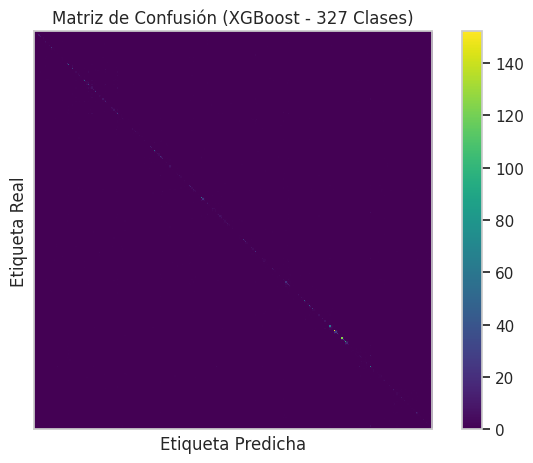

In [78]:
# Graficar la Matriz de Confusión
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis', colorbar=True, include_values=False) 

plt.title('Matriz de Confusión (XGBoost - 327 Clases)')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.xticks([]) 
plt.yticks([]) 
plt.tight_layout()
plt.savefig('xgb_confusion_matrix.png')

print("¡Gráfico 'xgb_confusion_matrix.png' guardado!")